### Resting State EEG: classic band power analysis
Spectral analysis using Welch's PSD estimation method and dividing the spectra by pre-defined frequency ranges to get band powers of interest.

In [29]:
# Import packages
import os, mne
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set default directory
os.chdir('/Users/tanijarv/Documents/GitHub/EEG-pyline')
mne.set_log_level('error')

# Import functions
import signal_processing.spectral_analysis as spectr
import basic.arrange_data as arrange

Define these variables!

In [30]:
# Folder where to get the clean epochs files
clean_folder = 'Data/Clean/'

# Folder where to save the results
results_foldername = 'Results/'

# Sub-folder for the experiment (i.e. timepoint or group) and its acronym
exp_folder = 'test_experiment'
exp_condition = 'EC_test'

# Band power names and frequency ranges
b_names = ['Delta', 'Theta', 'Alpha', 'Beta']
b_freqs = [[1, 3.9], [4, 7.9], [8, 12], [12.1, 30]]

# Brain regions and their channels
brain_regions = {'Left frontal' : ['AF3', 'F7', 'F3'],
                 'Right frontal' : ['AF4', 'F8', 'F4'],
                 'Left posterior' : ['CP5', 'P7', 'P3'],
                 'Right posterior' : ['CP6', 'P8', 'P4'],
                 'Midline frontal' : ['Fz'],
                 'Midline central' : ['Cz'],
                 'Midline posterior' : ['Pz']}

# Power spectra estimation parameters
psd_params = dict(method='welch', fminmax=[1, 30], window='hamming', window_duration=2.5,
                  window_overlap=0.5, zero_padding=9)

Run this to set the folders for data.

In [31]:
# Get directories of clean EEG files and set export directory
dir_inprogress = os.path.join(clean_folder,exp_folder)
file_dirs, subject_names = arrange.read_files(dir_inprogress,'_clean-epo.fif')

Files in Data/Clean/test_experiment read in: 1


Run this to analyse the EEG signal in the frequency domain (i.e. do spectral analysis) using Welch's PSD method and examining pre-defined frequency bands.

---
PSD (welch) calculation

<Power Spectrum (from Epochs, welch method) | 42 epochs × 32 channels × 726 freqs, 1.0-30.0 Hz>
Window type: hamming
Window size: 2560
Overlap: 1280
Zero-padding: 23040

Samples per segment: 2560
Samples for FFT: 25600
Frequency resolution: 0.040000000000000036 Hz


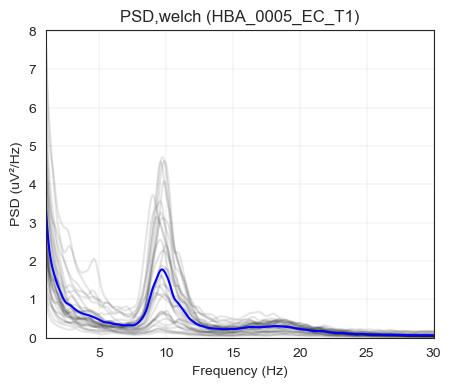

Finding bandpower within [1, 30] Hz with Ln normalisation set to False
Finding bandpower within [1, 3.9] Hz with Ln normalisation set to False
Finding bandpower within [4, 7.9] Hz with Ln normalisation set to False
Finding bandpower within [8, 12] Hz with Ln normalisation set to False
Finding bandpower within [12.1, 30] Hz with Ln normalisation set to False
---
Regional absolute powers in Delta band


,Left frontal,Right frontal,Left posterior,Right posterior,Midline frontal,Midline central,Midline posterior
Subject,,,,,,,
HBA_0005_EC_T1,1.522661,1.514578,0.997258,1.746733,0.306268,0.733358,1.055636


---
Regional absolute powers in Theta band


,Left frontal,Right frontal,Left posterior,Right posterior,Midline frontal,Midline central,Midline posterior
Subject,,,,,,,
HBA_0005_EC_T1,0.552997,0.436118,0.3651,0.610872,0.104335,0.244226,0.37427


---
Regional absolute powers in Alpha band


,Left frontal,Right frontal,Left posterior,Right posterior,Midline frontal,Midline central,Midline posterior
Subject,,,,,,,
HBA_0005_EC_T1,0.847687,0.666646,1.356659,1.599013,0.104926,0.391648,2.250586


---
Regional absolute powers in Beta band


,Left frontal,Right frontal,Left posterior,Right posterior,Midline frontal,Midline central,Midline posterior
Subject,,,,,,,
HBA_0005_EC_T1,0.17164,0.152269,0.198663,0.270257,0.038004,0.165318,0.231889


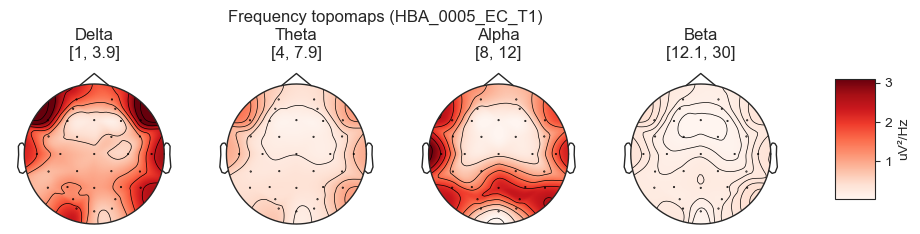

In [32]:
# Loop through all the subjects' directories (EEG files directories)
df_faa = pd.DataFrame(columns=['Pre-frontal','Mid-frontal','Lateral-frontal'])
for i in range(len(file_dirs)):
    # Read the clean data from the disk
    epochs = mne.read_epochs(fname='{}/{}_clean-epo.fif'.format(dir_inprogress, subject_names[i]),
                                                                verbose=False)
    
    # Calculate power spectra using Welch's PSD method
    [psds,freqs] = spectr.calculate_psd(epochs, subject_names[i], **psd_params,
                                        verbose=True, plot=True)

    # Total PSD of chosen frequency range (for later relative PSD calculation)
    psd_ch_allbands = spectr.bandpower_per_channel(psds, freqs, [b_freqs[0][0], b_freqs[-1][-1]],
                                                   'All bands', subject_names[i], epochs)
    
    # Find power for all bands and add to dataframe including the previous subjects
    for j in range(len(b_names)):
        if i == 0:
            globals()["df_psd_"+b_names[j]] = pd.DataFrame()
            globals()["df_rel_psd_"+b_names[j]] = pd.DataFrame()
        if j == 0:
            vlim = [float('inf'), 0]
        
        # Devide the PSD to frequency band bins and calculate absolute and relative bandpowers
        globals()["psd_ch_"+b_names[j]] = spectr.bandpower_per_channel(psds, freqs, b_freqs[j], b_names[j],
                                                                       subject_names[i], epochs)
        globals()["rel_psd_ch_"+b_names[j]] = globals()["psd_ch_"+b_names[j]] / psd_ch_allbands

        # Convert the array to dataframe and concatenate it to dataframe including the previous subjects
        globals()["temp_df_psd_"+b_names[j]] = arrange.array_to_df(subject_names[i], epochs,
                                                                   globals()["psd_ch_"+b_names[j]])
        globals()["df_psd_"+b_names[j]] = pd.concat([globals()["df_psd_"+b_names[j]],
                                                     globals()["temp_df_psd_"+b_names[j]]])
        globals()["temp_df_rel_psd_"+b_names[j]] = arrange.array_to_df(subject_names[i], epochs,
                                                                       globals()["rel_psd_ch_"+b_names[j]])
        globals()["df_rel_psd_"+b_names[j]] = pd.concat([globals()["df_rel_psd_"+b_names[j]],
                                                         globals()["temp_df_rel_psd_"+b_names[j]]])

        # Save the minimum and maximum PSD values as an integer for later colorbar use
        vlim[0] = min([vlim[0], min(globals()["psd_ch_"+b_names[j]])])
        vlim[1] = max([vlim[1], max(globals()["psd_ch_"+b_names[j]])])

    # Plot topomaps for all bands
    sns.set_style("white", {'font.family' : ['sans-serif']})
    fig,axs = plt.subplots(nrows=1, ncols=len(b_names), figsize=(10,3))
    fig.suptitle("Frequency topomaps ({})".format(subject_names[i]))
    for topo in range(len(b_names)):
        im,_ = mne.viz.plot_topomap(globals()["psd_ch_"+b_names[topo]], epochs.info, axes=axs[topo],
                                    vlim=vlim, show=False)
        axs[topo].set_title(b_names[topo]+'\n'+str(b_freqs[topo]))
    cbar_ax = fig.add_axes([0.95, 0.35, 0.04, 0.4])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_ylabel('uV\u00b2/Hz')

# Calculate alpha asymmetry for three channel pairs
df_faa['Pre-frontal'] = spectr.calculate_asymmetry_ch(df_psd_Alpha,'Fp1','Fp2')
df_faa['Mid-frontal'] = spectr.calculate_asymmetry_ch(df_psd_Alpha,'F3','F4')
df_faa['Lateral-frontal'] = spectr.calculate_asymmetry_ch(df_psd_Alpha,'F7','F8')

# Pre-create results folders for spectral analysis data
arrange.create_results_folders(exp_folder=exp_folder, results_folder=results_foldername, 
                               abs_psd=True, rel_psd=True)

# Export power spectra data for each band
for band in b_names:
    # Save the PSD values for each channel for each band in Excel format
    globals()["df_psd_"+band].to_excel('{}/{}/Absolute PSD/channels/{}_psd_{}.xlsx'.format(results_foldername,
                                                                                           exp_folder,
                                                                                           exp_condition,
                                                                                           band))

    # Find regional band powers and display and save them to Excel
    df_psd_band_reg = arrange.df_channels_to_regions(globals()["df_psd_"+band], brain_regions)
    df_psd_band_reg.to_excel('{}/{}/Absolute PSD/regions/{}_psd_{}.xlsx'.format(results_foldername, exp_folder,
                                                                                exp_condition, band))
    print('---\nRegional absolute powers in {} band'. format(band))
    display(df_psd_band_reg.head())

# Export asymmetry data
df_faa.to_excel('{}/{}/Absolute PSD/{}_frontal_asymmetry.xlsx'.format(results_foldername, exp_folder, exp_condition))